<a href="https://colab.research.google.com/github/kleenman/tds_capstone/blob/pedro/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from fastai.vision.all import *

In [3]:
dataset_path = '/content/gdrive/MyDrive/Capstone/Data/munich_data'

# define mask function

def mask_function(name):
  img_name = str(name).split('/')[-1]
  mask_path = dataset_path + '/masks/' + img_name.replace('.jpg', '.npy')
  return np.load(mask_path)


In [4]:
# Create datablock
parks_block = DataBlock(blocks = (ImageBlock, MaskBlock(codes = ['background','park'])),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=mask_function,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=256, max_lighting=0.3)
)

# Dataloaders with batch size 4

dls16 = parks_block.dataloaders(dataset_path, bs=4)

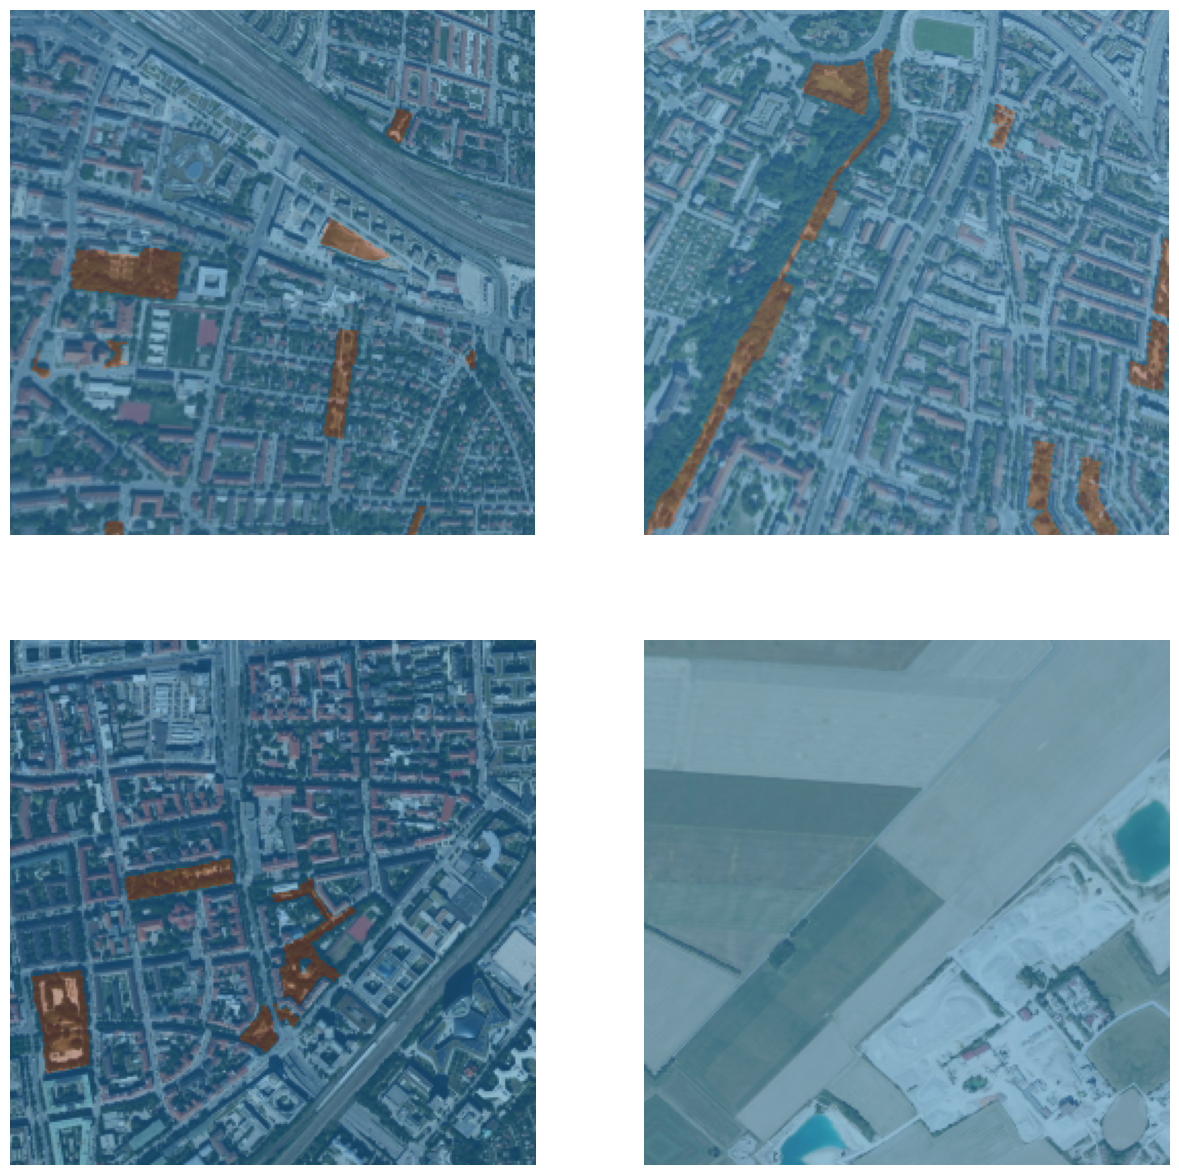

In [5]:
dls16.show_batch(figsize=(15, 15))

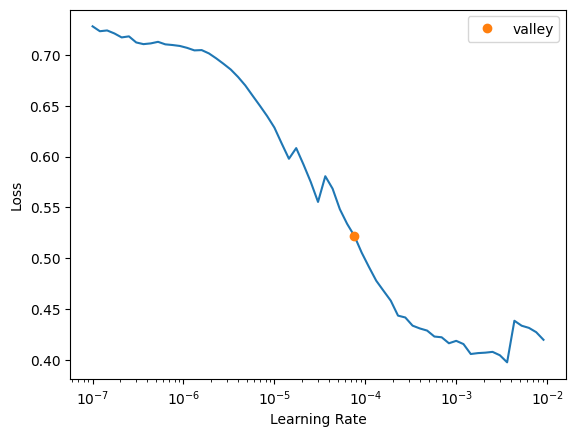

In [7]:
# Create a U-Net model
learn_RELU = unet_learner(dls16,resnet34,metrics=Dice)
lr_RELU = learn_RELU.lr_find()

In [8]:
# Train the U-Net model.
learn_RELU.fit_one_cycle(40, lr_max=lr_RELU.valley, cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
                                           SaveModelCallback(monitor='dice', min_delta=0.01, comp=np.greater, fname='best_frozen_RELU')])

epoch,train_loss,valid_loss,dice,time
0,0.327334,0.278404,0.001439,00:41
1,0.297392,0.278885,0.000306,00:26
2,0.263044,0.236624,0.000006,00:25
3,0.258096,0.211728,0.000312,00:26
4,0.241344,0.201114,0.000000,00:24
5,0.227047,0.192174,0.003824,00:25
6,0.234342,0.193776,0.000351,00:27
7,0.219193,0.228056,0.167679,00:24
8,0.214576,0.221698,0.454974,00:27
9,0.204300,0.255243,0.412365,00:26


Better model found at epoch 0 with dice value: 0.0014386704700483691.
Better model found at epoch 7 with dice value: 0.1676785848137321.
Better model found at epoch 8 with dice value: 0.45497375731477147.
No improvement since epoch 8: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


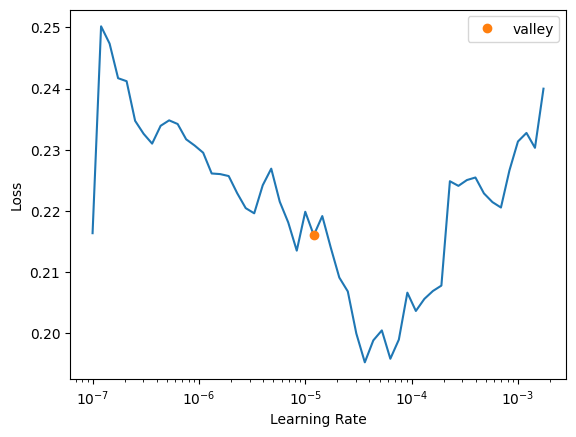

In [9]:
# Unfreeze the last layers of the model
learn_RELU = learn_RELU.load('best_frozen_RELU')
learn_RELU.unfreeze()
lr_RELU = learn_RELU.lr_find()

In [10]:
# Train the last layers
learn_RELU.fit_one_cycle(
    40, lr_max=slice(lr_RELU.valley/10,lr_RELU.valley*10),
    cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
         SaveModelCallback(monitor='dice', comp=np.greater, fname='best_model_RELU')]
         )



epoch,train_loss,valid_loss,dice,time
0,0.188253,0.181267,0.416226,00:26
1,0.176591,0.178547,0.429117,00:26
2,0.186216,0.180148,0.399344,00:25
3,0.202100,0.196170,0.442844,00:25
4,0.195544,0.192506,0.330111,00:26
5,0.201637,0.198383,0.412367,00:25
6,0.189070,0.201237,0.037488,00:25
7,0.195679,0.182412,0.071862,00:28
8,0.184340,0.180694,0.340552,00:24
9,0.185829,0.177422,0.374553,00:26


Better model found at epoch 0 with dice value: 0.4162262529012293.
Better model found at epoch 1 with dice value: 0.42911657475618.
Better model found at epoch 3 with dice value: 0.442843949340989.
Better model found at epoch 11 with dice value: 0.4965911975227169.
No improvement since epoch 11: early stopping


In [11]:
learn_RELU = learn_RELU.load("best_model_RELU")
print("in-sample performance: {}".format(np.array(learn_RELU.validate(ds_idx=0)[1])))

in-sample performance: 0.6370930227881768


In [12]:
print("out-of-sample performance: {}".format(np.array(learn_RELU.validate(ds_idx=1)[1])))

out-of-sample performance: 0.4965911975227169


In the next sections we will experiment with different activation functions (ELU, LeakyReLU, GELU) with the U-Net architecture and resnet34 model, while keeping all transformations and batch size constant.


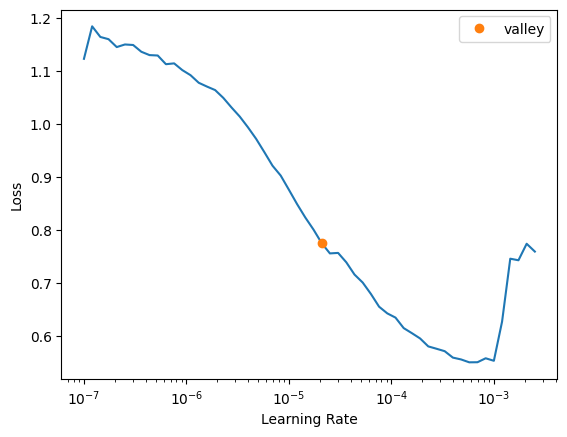

In [13]:
# Exponential Linear Unit (ELU) activation function:

learn_ELU = unet_learner(dls16, resnet34, metrics=Dice, act_cls=torch.nn.modules.activation.ELU)
lr_ELU = learn_ELU.lr_find()

In [14]:
# Train the first layers of the ELU activated model:

learn_ELU.fit_one_cycle(40, lr_max=lr_ELU.valley, cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
                                           SaveModelCallback(monitor='dice', min_delta=0.01, comp=np.greater, fname='best_frozen_ELU')])

epoch,train_loss,valid_loss,dice,time
0,0.476923,0.321021,0.043354,00:24
1,0.342197,0.280127,0.017632,00:25
2,0.281205,0.254083,0.009592,00:26
3,0.285644,0.233946,0.107596,00:24
4,0.245980,0.218506,0.056528,00:25
5,0.234739,0.196971,0.228062,00:26
6,0.222928,0.258520,0.431805,00:24
7,0.226282,0.190346,0.344281,00:26
8,0.210581,0.192635,0.219906,00:26
9,0.214610,0.186056,0.404564,00:26


Better model found at epoch 0 with dice value: 0.043353868302938726.
Better model found at epoch 3 with dice value: 0.10759600744374895.
Better model found at epoch 5 with dice value: 0.22806178733606836.
Better model found at epoch 6 with dice value: 0.43180491530509263.
Better model found at epoch 16 with dice value: 0.4740319782729849.
No improvement since epoch 16: early stopping


The ELU activation function drastically accelerated the learning process of the model. A dice score of over 0.5 was reached as soon as epoch 19 of training, as opposed to the previous model, which used the Rectified Linear Unit activation function, and reached a comparable dice score only after unfreezing its last layers.

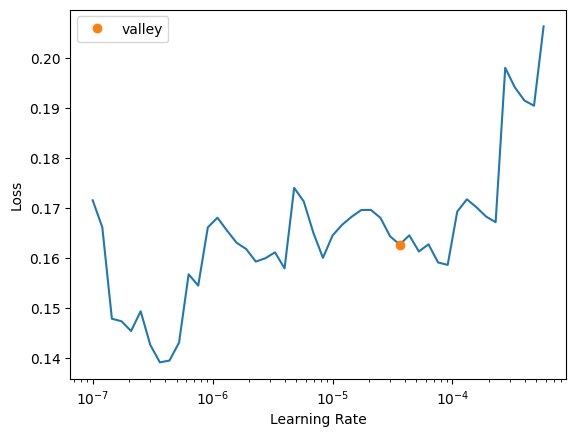

In [18]:
# learn_ELU = learn_ELU.load('best_frozen_ELU')
learn_ELU.unfreeze()
lr_ELU = learn_ELU.lr_find()

In [19]:
# Train the last layers
learn_ELU.fit_one_cycle(
    40, lr_max=slice(lr_ELU.valley/10,lr_ELU.valley*10),
    cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
         SaveModelCallback(monitor='dice', comp=np.greater, fname='best_ELU_model')]
         )

epoch,train_loss,valid_loss,dice,time
0,0.178618,0.183132,0.483232,00:26
1,0.176630,0.186500,0.435819,00:26
2,0.190530,0.213667,0.359438,00:27
3,0.184827,0.177696,0.055597,00:26
4,0.212511,0.190199,0.400854,00:26
5,0.222503,0.188776,0.003225,00:27
6,0.245730,0.190386,0.302051,00:27
7,0.224455,0.184730,0.013966,00:26
8,0.221193,0.216268,0.000000,00:26
9,0.212097,0.182236,0.367694,00:26


Better model found at epoch 0 with dice value: 0.4832319307748004.
No improvement since epoch 0: early stopping


In [20]:
learn_ELU = learn_ELU.load("best_ELU_model")
print("in-sample performance: {}".format(np.array(learn_ELU.validate(ds_idx=0)[1])))

in-sample performance: 0.6061484367936777


In [21]:
print("our-of-sample performance: {}".format(np.array(learn_ELU.validate(ds_idx=1)[1])))

our-of-sample performance: 0.4832319307748004


The ELU activation function provided slightly better performance than RELU.
Next, we will try the LeakyRELU activation function.

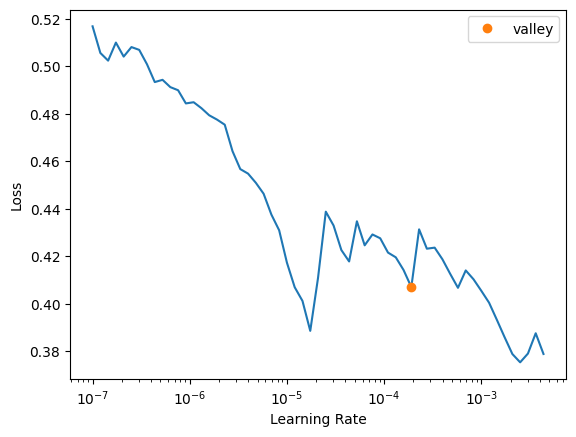

In [22]:
learn_leaky = unet_learner(dls16, resnet34, metrics=Dice, act_cls=torch.nn.modules.activation.LeakyReLU)
lr_leaky = learn_leaky.lr_find()

In [23]:
learn_leaky.fit_one_cycle(40, lr_max=lr_leaky.valley, cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
                                           SaveModelCallback(monitor='dice', min_delta=0.01, comp=np.greater, fname='best_frozen_leaky')])

epoch,train_loss,valid_loss,dice,time
0,0.296066,0.254620,0.000477,00:26
1,0.262057,0.295856,0.000000,00:24
2,0.247390,0.276950,0.000512,00:25
3,0.265831,0.229329,0.000000,00:25
4,0.247856,0.206358,0.000000,00:27
5,0.245642,0.215715,0.000000,00:26
6,0.260453,0.223208,0.000000,00:24
7,0.240072,0.197867,0.000000,00:26
8,0.228215,0.209246,0.000000,00:26
9,0.213888,0.191162,0.000000,00:25


Better model found at epoch 0 with dice value: 0.0004773044508640043.
Better model found at epoch 10 with dice value: 0.1790096806071247.
Better model found at epoch 12 with dice value: 0.2697669747763403.
Better model found at epoch 14 with dice value: 0.423940067234387.
Better model found at epoch 15 with dice value: 0.4703555437769378.
Better model found at epoch 22 with dice value: 0.48836497283233543.
Better model found at epoch 23 with dice value: 0.506056891493314.
No improvement since epoch 23: early stopping


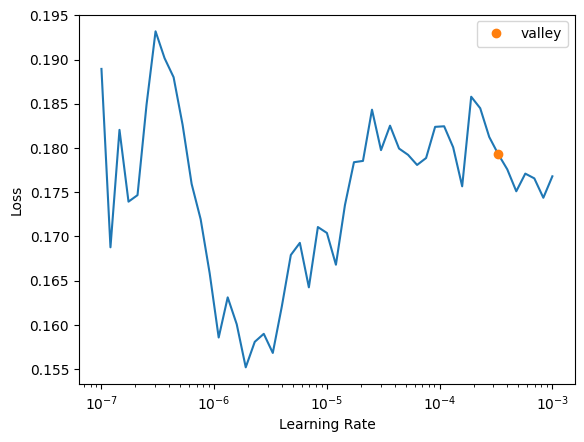

In [24]:
learn_leaky = learn_leaky.load('best_frozen_leaky')
learn_leaky.unfreeze()
lr_leaky = learn_ELU.lr_find()

In [25]:
learn_leaky.fit_one_cycle(
    40, lr_max=slice(lr_leaky.valley/10,lr_leaky.valley*10),
    cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
         SaveModelCallback(monitor='dice', comp=np.greater, fname='best_leaky_model')]
         )

epoch,train_loss,valid_loss,dice,time
0,0.146425,0.174610,0.467420,00:26
1,0.167756,0.167461,0.369700,00:27
2,0.184765,0.224780,0.113848,00:28
3,0.213450,0.272900,0.000000,00:26
4,0.239815,0.217517,0.000000,00:27
5,11.802354,53.786659,0.000000,00:28
6,437.868347,1263.276611,0.028060,00:27
7,70727.476562,3503.304199,0.000000,00:27
8,692135488.000000,16570954.000000,0.000000,00:27
9,155845552.000000,1833.605957,0.000000,00:27


Better model found at epoch 0 with dice value: 0.46741993732231574.
No improvement since epoch 0: early stopping


In [26]:
learn_leaky = learn_leaky.load("best_leaky_model")
print("in-sample performance: {}".format(np.array(learn_leaky.validate(ds_idx=0)[1])))

in-sample performance: 0.6656679598129911


In [27]:
print("out-of-sample performance: {}".format(np.array(learn_leaky.validate(ds_idx=1)[1])))

out-of-sample performance: 0.46741993732231574


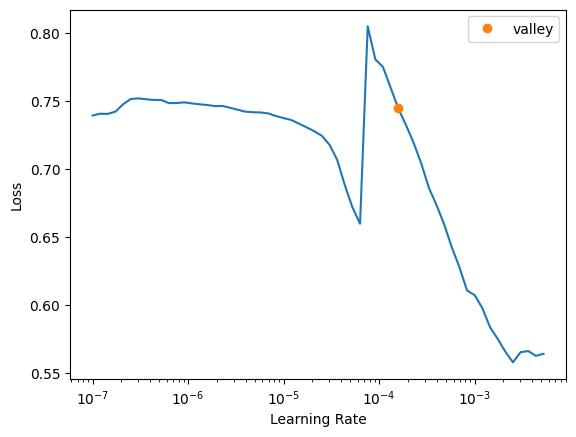

In [28]:
learn_GELU = unet_learner(dls16, resnet34, metrics=Dice, act_cls=torch.nn.GELU)
lr_GELU = learn_GELU.lr_find()

In [29]:
learn_GELU.fit_one_cycle(40, lr_max=lr_GELU.valley, cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
                                           SaveModelCallback(monitor='dice', min_delta=0.01, comp=np.greater, fname='best_frozen_gelu')])

epoch,train_loss,valid_loss,dice,time
0,0.394389,0.288173,0.001353,00:26
1,0.299456,0.245241,0.000228,00:26
2,0.275063,0.229343,0.000217,00:25
3,0.236219,0.196129,0.000585,00:26
4,0.242899,0.208794,0.000045,00:25
5,0.223501,0.191089,0.000067,00:25
6,0.216279,0.204719,0.053061,00:26
7,0.201443,0.185380,0.401923,00:25
8,0.200430,0.194596,0.417265,00:25
9,0.191143,0.175862,0.409701,00:25


Better model found at epoch 0 with dice value: 0.0013532283572852918.
Better model found at epoch 6 with dice value: 0.05306132377624079.
Better model found at epoch 7 with dice value: 0.40192301636453337.
Better model found at epoch 8 with dice value: 0.4172652986338489.
Better model found at epoch 10 with dice value: 0.4291859827129669.
Better model found at epoch 13 with dice value: 0.5129746870986945.
No improvement since epoch 13: early stopping


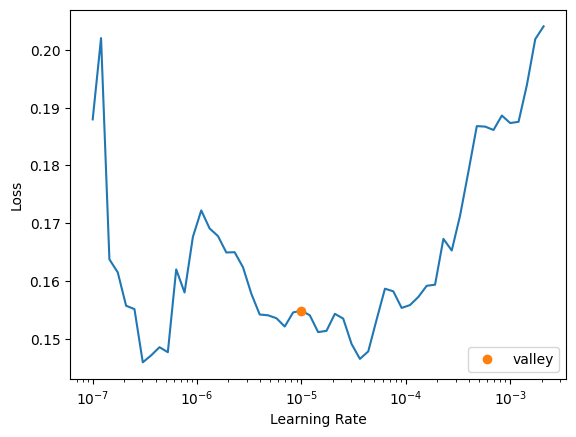

In [30]:
learn_GELU = learn_GELU.load('best_frozen_gelu')
learn_GELU.unfreeze()
lr_GELU = learn_GELU.lr_find()

In [31]:
learn_GELU.fit_one_cycle(
    40, lr_max=slice(lr_GELU.valley/10,lr_GELU.valley*10),
    cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
         SaveModelCallback(monitor='dice', comp=np.greater, fname='best_gelu_model')]
         )

epoch,train_loss,valid_loss,dice,time
0,0.141648,0.168895,0.456598,00:26
1,0.143273,0.171275,0.480106,00:26
2,0.138443,0.183477,0.498496,00:26
3,0.131392,0.173772,0.472251,00:25
4,0.144733,0.175307,0.374917,00:26
5,0.130554,0.165464,0.432710,00:27
6,0.126496,0.189704,0.430097,00:25
7,0.132377,0.167630,0.347795,00:26
8,0.122052,0.216823,0.462223,00:26
9,0.129020,0.176535,0.517563,00:26


Better model found at epoch 0 with dice value: 0.45659788240088695.
Better model found at epoch 1 with dice value: 0.48010571868715973.
Better model found at epoch 2 with dice value: 0.49849597308923893.
Better model found at epoch 9 with dice value: 0.5175632558314762.
Better model found at epoch 17 with dice value: 0.5289540724362518.
Better model found at epoch 22 with dice value: 0.5429130910556932.
No improvement since epoch 22: early stopping


In [32]:
learn_GELU = learn_GELU.load("best_gelu_model")
print("in-sample performance: {}".format(np.array(learn_GELU.validate(ds_idx=0)[1])))

in-sample performance: 0.8462976656427047


In [33]:
print("out-of-sample performance: {}".format(np.array(learn_GELU.validate(ds_idx=1)[1])))

out-of-sample performance: 0.5429130910556932
